In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Connectomes and network analysis
import conntility
# Specific to this project
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome
from utils_microns_bbp import *
from plotting_utils import *

In [2]:
# Get node based data 
configs={} #Paths to activity and structural data 

# Paths to data and specs 
configs["BBP"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline/working_dir/reliability_basic.npz",
    "fname_CC": "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/toposample_input/raw_spikes_exc.npy",
    "format_rates":"toposample",
    "bin_size":"2p0", 
    "fname_effciency":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl",
    "properties":["CC", "CC_norm_cell", "reliability", "efficiency"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

configs["MICrONS"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "fname_CC": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "format_rates":None,
    "bin_size":None, 
    "save_dir":"../../data", 
    "average_type":["per_layer", "full"], 
    "properties":["CC", "CC_norm_cell", "reliability"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

connectomes, simp_layer_raw, simp_full_raw ={}, {}, {}

#Load precomputed data 
conns=["MICrONS", "BBP"]
for conn in conns:
    cfg=configs[conn]
    stypes=cfg["stypes"]
    base_graph=cfg["base_graph"]
    # Get connectome and porperties per node 
    connectome=load_connectome(cfg["connectome_dir"], conn)
    connectome = add_layers(connectome,conn)
    connectome = add_reliability(connectome, conn, cfg["fname_reliability"])
    connectome = add_firing_rates(connectome,conn, cfg["fname_rates"], cfg["format_rates"]) 
    for norm_type in cfg["norm_types"]:
        connectome = add_cc(connectome, cfg["fname_CC"], norm_type)#, bin_size=cfg["bin_size"]) double check bin size option 
    connectomes[conn]=connectome
    # Adding properties of neighbohoords 
    nbd_props=pd.read_pickle(f'/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_{conn}_original.pkl')
    for col in nbd_props.columns:
        connectomes[conn].add_vertex_property(new_label=col,new_values=nbd_props[col].to_numpy())
    
# Load dimension of activity (BBP only)
conn="BBP"
connectomes[conn]=add_efficiency(connectomes[conn], configs[conn]["fname_effciency"])


In [3]:
# Get top and bottom complexity neighborhoods with active centers
complexity_metric="euclidean_edges_sc"
for conn in conns:
    df=connectomes[conn].vertices
    activity_properties = ["reliability"]
    for activity_property in activity_properties:
        tresh=100/(~np.isnan(df[activity_property])).sum() # Fixed sample size 100 centers
        # Restrict to centers with co-registered activity metric
        x=(df[~np.isnan(df[activity_property])])[complexity_metric] 
        df[('nbd_complexity', activity_property)]=np.nan
        # Sparse ones
        df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
        # Dense ones
        df[('nbd_complexity', activity_property)][df[complexity_metric]>np.quantile(x, 1-tresh)]='high complexity'
        connectomes[conn].add_vertex_property(new_label=('nbd_complexity', activity_property),new_values=df[('nbd_complexity', activity_property)].to_numpy())



/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197443/2416714917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197443/2416714917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'


In [4]:
# Get simplicial structure reliability
for conn in conns: 
    cfg=configs[conn]
    simp_layer_raw[conn], simp_full_raw[conn] ={}, {}
    for property in cfg["properties"]:
        fname=f"{cfg['simplicial_dir']}/node_stats_per_layer_{property}_{conn}_{base_graph}.pkl"
        simp_layer_raw[conn][property]=pd.read_pickle(fname)
        fname=f"{cfg['simplicial_dir']}/node_stats_full_{property}_{conn}_{base_graph}.pkl"
        simp_full_raw[conn][property]=pd.read_pickle(fname)

# Reformat for plotting 
simplicial_full=agg_along_dims_single(simp_full_raw)
simplicial_layers=agg_along_dims_layers(simp_layer_raw)


# Plotting basics 

In [5]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3),
    "all":"C0",
    "sink": "C1",
    "source":"C2",
    'BBP':"steelblue", 
    'MICrONS':"palevioletred"
}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
alpha=0.25

In [6]:
def plot_and_fill_all_positions(ax, dict, colors, marker_size, markers, alpha):
    for pos in ["source", "all", "sink"]: 
        df=dict[pos]
        plot_and_fill(ax, df, pos, colors[pos], marker_size, markers[pos], alpha)                        
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(labelsize=ticksize)
    h,l = ax.get_legend_handles_labels()
    return ax,h,l

# Supplementary figure

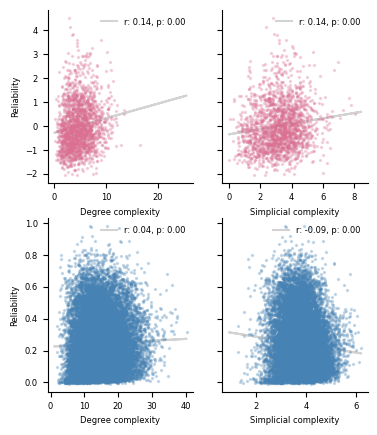

In [7]:
width=21*0.5/conversion

rows=2; cols=2
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows*1.2/cols), sharey='row')
property='reliability'
for i, conn in enumerate(conns):
    for j, (cpx, cpx_label) in enumerate([('wasserstein_deg_total', 'Degree'),('euclidean_edges_sc', 'Simplicial')]): 
        axs[i,j], h,l=scatter_and_regress(axs[i,j], connectomes[conn].vertices[cpx], connectomes[conn].vertices[property],
                                          colors[conn], marker='o', 
                                          marker_size=marker_size, color_regress="lightgray", alpha=0.25,
                                         add_pvalue=True)
        axs[i,j].legend([h[0]],l, frameon=False, fontsize=labelsize)
        axs[i,0].legend(frameon=False, fontsize=labelsize)
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,j].set_xlabel(f"{cpx_label} complexity", fontsize=labelsize)
        axs[i,j].tick_params(axis='both', labelsize=ticksize)
    axs[i,0].set_ylabel(f"Reliability", fontsize=labelsize)
fig.savefig(f"figs/reliab_complexity_regression.svg", transparent=True, bbox_inches="tight")

# Main Figure

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197443/186046297.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197443/186046297.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1




For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=24.55393432835831, pvalue=7.225865396491437e-07)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=4.093038805970195, pvalue=0.043060158723458586)


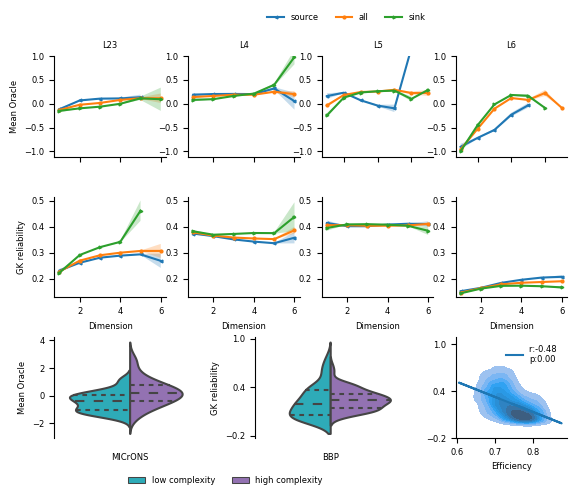

In [8]:
width=21*0.8/conversion
rows=3; cols=4
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols))

#### Simplicial structure
stype="maximal" # Consider maximal simplices
property="reliability"
for i, conn in enumerate(conns):
    for j, layer in enumerate(simplicial_layers.keys()):
        dict=simplicial_layers[layer][conn][property][stype] 
        axs[i,j], h,l =plot_and_fill_all_positions(axs[i,j], dict, colors, marker_size, markers, alpha)
        axs[i,j].set_xlabel("Dimension", fontsize=labelsize)
        axs[0,j].set_title(layer, fontsize=labelsize)
        # Share x-axis first two rows
        axs[0,j].set_xticks([2,4,6], labels=["", "", ""])
        axs[1,j].set_xticks([2,4,6])
        axs[0,j].set_xlabel("")
        axs[1,j].set_xlabel("Dimension")
    # Make shared y-axis across connectomes 
    y_min=min([axs[i,k].get_ylim()[0] for k in range(cols)])-0.01
    y_max=min(1, max([axs[i,k].get_ylim()[1] for k in range(cols)]))
    for ax in axs[i,:]:
        ax.set_ylim(y_min, y_max)
axs[0,2].legend(frameon=False,fontsize=labelsize, ncols=3,bbox_to_anchor=(1,1.5))

# CHAMPIONS
# Rearrange axis because they need more space 
axs[2,0].axis("off")
axs[2,1].axis("off")
axs[2,2].axis("off")
ax_extremals=[]
y0, width, height=0, 3/2, 1
ax_extremals.append(axs[2,0].inset_axes([0, y0, width*0.9, height])) 
ax_extremals.append(axs[2,0].inset_axes([0+width*1.2, y0, width*0.9, height])) 


for j, conn in enumerate(conns):
    property="reliability"
    df=connectomes[conn].vertices
    data=df[np.logical_or(df[("nbd_complexity", property)]=="high complexity", 
                          df[("nbd_complexity", property)]=="low complexity")]
    data["dummy"]=1
    x=data[data[('nbd_complexity', property)]== 'low complexity'][property].to_numpy()
    y=data[data[('nbd_complexity', property)]== 'high complexity'][property].to_numpy()
    x=x[~np.isnan(x)]; y=y[~np.isnan(y)]
    print(f"\n\nFor connectome {conn}")
    print(f"Sample size {x.shape[0]}, {y.shape[0]}")
    print(f"Kruskal-Wallis H-test {stats.kruskal(x, y)}")
    
    #Plot violins 
    ax_extremals[j]=plot_violin(ax_extremals[j], y=property, data=data, hue=("nbd_complexity", property))
    ax_extremals[j].get_legend().remove()
    ax_extremals[j].tick_params(axis='both', labelsize=ticksize)
    ax_extremals[j].set_ylabel("",fontsize=labelsize)
    ax_extremals[j].spines[["right", "top", "bottom"]].set_visible(False)
    ax_extremals[j].set_title(conn,fontsize=labelsize,y=-0.3)

#### Scatter and regression
conn="BBP"
df=connectomes[conn].vertices
y=df["reliability"].astype("float")
x=df["efficiency"].astype("float")
color="C0"#df["rates"]
axs[2,3], h, l, regress=kde_and_regress(axs[2,3],df,y="reliability", x="efficiency", color=color, return_stats=True)
axs[2,3].spines[["top", "right"]].set_visible(False) 
labels=[f"r:{regress.rvalue:.2f} \np:{regress.pvalue:.2f}"]
axs[2,3].legend([h[0]], labels, frameon=False, fontsize=labelsize, loc="upper right")
axs[2,3].set_xlabel("Efficiency", fontsize=labelsize)
axs[2,3].tick_params(axis='both', labelsize=ticksize)

for ax in [ax_extremals[1], axs[2,3]]:
    ax.set_yticks([-0.2,  0.4,  1])

# Labels
axs[0,0].set_ylabel("Mean Oracle", fontsize=labelsize)
axs[1,0].set_ylabel("GK reliability", fontsize=labelsize)
ax_extremals[0].set_ylabel("Mean Oracle", fontsize=labelsize)
ax_extremals[1].set_ylabel("GK reliability", fontsize=labelsize)
ax_extremals[1].legend(fontsize=labelsize, frameon=False,ncols=2, bbox_to_anchor=(0.5,-0.3))

plt.subplots_adjust(hspace=0.4)
fig.savefig(f"figs/reliab_dimension_both_connectomes.pdf", transparent=True, bbox_inches="tight")